In [1]:
!pip install opencv-python

In [3]:
import cv2
import patch_extraction as ext
import VAE
import os
import torch
import numpy as np
from VAE.models.vanilla_vae import VanillaVAE

In [4]:
def extract_patch(image):

    # Compute scores
    patch_scores = ext.compute_gradient_scores(image, patch_size=64, stride=64//2)

    # Keep top 10%
    n_top = int(len(patch_scores)*0.90)
    top_patches = ext.get_top_patches(patch_scores, top_k=n_top)

    # Extract patches
    return top_patches, ext.extract_patches_array_with_dog(image, top_patches, 
                                                          34, top_k=5, apply_dog_to_patches=True,
                                                          dog_sigma1= 1.0, dog_sigma2=2.0)
#on modifiera cette méthode pour obtenir des patchs aléatoirement plutôt que prendre les 5 meilleurs


In [5]:
device = torch.device('cuda')
vae_model = VanillaVAE(in_channels=1, latent_dim=64, kld_weight=1e-3).to(device)
checkpoint = torch.load("./vae_checkpoint_epoch4_batch44345.pt", map_location=torch.device('cuda'))
vae_model.load_state_dict(checkpoint['model_state_dict'])
vae_model.eval()

C:\Users\PresiJean\AppData\Local\Temp\ipykernel_2544\1622258849.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./vae_checkpoint_epoch4_batch443

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Se

(5, 34, 34)


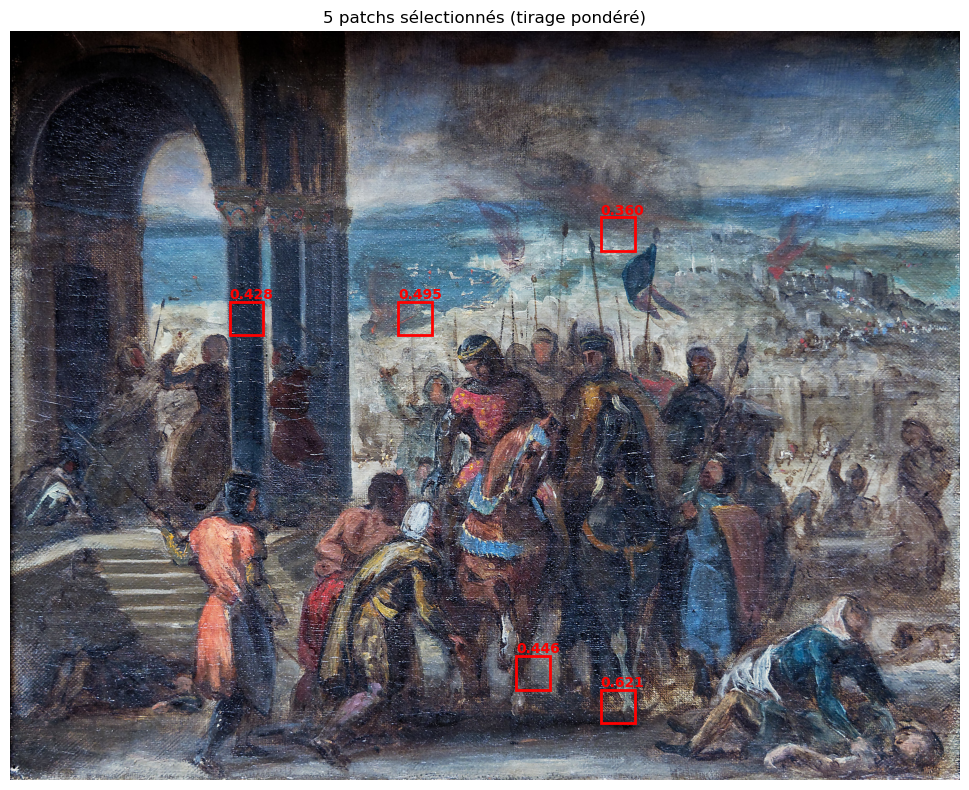

In [7]:
data_path = "C:/Users/PresiJean/Documents/github/IMA206/Data/delacroix - eugene-delacroix_1798/delacroix_17.jpg"
with torch.no_grad() :
    #Extraction des patchs de l'image
    image = cv2.imread(data_path)
    if image is None:
        print(f"Could not read image: {data_path}") 

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    patch_scores, selected_patches = extract_patch(image)
    print(selected_patches.shape)
    ext.visualize_patches(image, patch_scores, patch_size=64, k = 5)

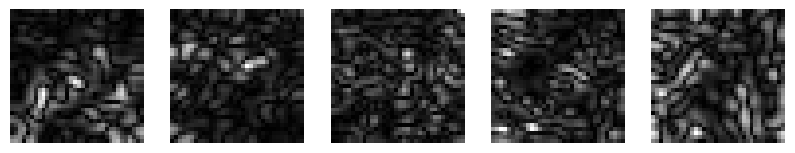

In [8]:
import matplotlib.pyplot as plt
# Visualize the selected patches
plt.figure(figsize=(10, 10))   
for i, patch in enumerate(selected_patches):
    plt.subplot(1, len(selected_patches), i + 1)
    plt.imshow(patch, cmap='gray')
    plt.axis('off')

In [9]:
embedding = []

for patch in selected_patches:
    # Convert to tensor and shape: (1, 1, H, W)
    patch_tensor = torch.tensor(patch).unsqueeze(0).unsqueeze(0).float().to(device)

    # Pass through VAE encoder
    z, _ = vae_model.encode(patch_tensor)  # z is shape (1, latent_dim)
    z = z.squeeze(0)  # shape: (latent_dim,) or (latent_dim, 1)

    embedding.append(z)

# Stack into a single tensor of shape (n_patches, latent_dim, latent_dim)
merged_embedding = torch.cat(embedding, dim=0)  # shape: (5*d,)

In [10]:
merged_embedding.size()

torch.Size([320])